In [17]:
from mesa.time import BaseScheduler
from mesa import Agent, Model
import random
import numpy as np
from scipy.stats import norm
import pprint

class Scientist(Agent):
    def __init__(self, curr_time, k, means, std_devs, total_self_effort, total_ideas, current_idea_effort, max_idea_effort, model):
#         super().__init__(k, means, std_devs, total_self_effort, self_invested_effort, total_ideas, current_idea_effort, max_idea_effort)
        
        # Scalar: what time period this Scientist was born
        self.time_born = curr_time
        
        # Scalar: total effort a scientist gets per time period
        self.total_self_effort = total_self_effort
        
        # Scalar: remaining effort a Scientist has left
        self.self_effort_left = total_self_effort
        
        # Array keeping track of how much effort this scientist has invested in each idea
        self.self_invested_effort = np.zeros(total_ideas)
        
        # Array keeping track of the k for each idea
        self.k = k.copy()
        
        # Array keeping track of the mean of the return curve for each idea
        # TODO: need to add noise
        self.means = means.copy()
        
        # Array keeping track of the standard deviations of the return curve for each idea
        # TODO: need to add noise
        self.std_devs = std_devs.copy()
        
        # Scalar: number of total ideas created throughout the simulation
        self.total_ideas = total_ideas
        
        # Array keeping track of how much effort has collectively been spent on each idea
        self.current_idea_effort = current_idea_effort
        
        # Array keeping track of the maximum effort allowed on each idea
        self.max_idea_effort = max_idea_effort

    
    def step(self):
        # Prints out each of the scientist attributes before the step starts
        print(' ')
        print("SCIENTIST BEFORE")
        print(' ')
        pprint.pprint(self.__dict__, width=1)
        
        # Pick ideas scientist can work on according to three criteria:
        # 1. the scientist has enough effort left to cover the entry cost "k"
        # 2. the idea has not reached the maximum effort allowed on it
        # 3. the idea was created either in this time period, or the previous time period (CAN BE CHANGED)
        avail = np.nonzero((self.k < self.self_effort_left) & (self.current_idea_effort < self.max_idea_effort))[0]
        
        # Make sure criteria 3 is fulfilled
        idea_time_period = avail//ideas_per_cycle
        crit_3_indices = np.nonzero((idea_time_period == self.time_born) | (idea_time_period == self.time_born - 1))[0]
        avail = avail[crit_3_indices]
        
        # Return if the Scientist can't work on any ideas
        if len(avail) == 0:
            return
        
        avail_idea_effort = self.current_idea_effort[avail]
        avail_means = self.means[avail]
        avail_std_devs = self.std_devs[avail]
        
        # Pick which idea to work on based on highest return
        current_returns = norm.cdf(avail_idea_effort, avail_means, avail_std_devs)
#         unit_to_invest = 1
        potential_returns = norm.cdf(avail_idea_effort + self.self_effort_left - self.k[avail], avail_means, avail_std_devs)
        
        # Returns index for which idea to invest in
        idea_to_invest_in = np.argmax(potential_returns - current_returns)
                
        # Pay the entrance cost to work on the idea "k"
        self.self_effort_left -= self.k[avail[idea_to_invest_in]]
                
        # Invest in idea with highest potential return (Note: pass by value)
        self.current_idea_effort[avail[idea_to_invest_in]] += self.self_effort_left
        self.self_invested_effort[avail[idea_to_invest_in]] += self.self_effort_left

        # Reset amount of effort for next time period
        self.self_effort_left = self.total_self_effort

        # Prints out each of the scientist attributes after the step has been completed
        print(' ')
        print("SCIENTIST AFTER")
        print(' ')
        pprint.pprint(self.__dict__, width=1)


class ScientistModel(Model):
    def __init__(self, scientists_per_cycle, ideas_per_cycle, cycles, granularity, true_means, true_std_devs, starting_effort, max_idea_effort):
        self.total_scientists = scientists_per_cycle * cycles
        self.total_ideas = ideas_per_cycle * cycles
        self.granularity = granularity
        self.current_idea_effort = np.zeros(self.total_ideas)
        self.max_idea_effort = max_idea_effort

        self.schedule = BaseScheduler(self) # has a .time() function

        self.k = k = 1 * np.ones(total_ideas) # TODO: must vary this for each scientist
        self.means = true_means # TODO: must vary this for each scientist
#         self.means[0] = 2
        self.std_devs = true_std_devs # TODO: must vary this for each scientist
        self.total_self_effort = starting_effort # TODO: must vary this for each scientist

    def step(self):
        for i in range(scientists_per_cycle):
            a = Scientist(self.schedule.time, self.k, self.means, self.std_devs, self.total_self_effort, self.total_ideas, self.current_idea_effort, self.max_idea_effort, self)
            self.schedule.add(a)
        self.schedule.step()

In [18]:
# SAMPLE RUN
cycles = 5
ideas_per_cycle = 2
scientists_per_cycle = 2
granularity = 1
total_ideas = cycles * ideas_per_cycle
true_means = 50 * np.ones(total_ideas)
true_std_devs = 1.2 * np.ones(total_ideas)
starting_effort = 10
max_idea_effort = 100 * np.ones(total_ideas)
model = ScientistModel(scientists_per_cycle, ideas_per_cycle, cycles, granularity, true_means, true_std_devs, starting_effort, max_idea_effort)
for i in range(cycles):
    print(' ')
    print("CYCLE ", i)
    print(' ')
    model.step()

 
CYCLE  0
 
 
SCIENTIST BEFORE
 
{'current_idea_effort': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 'k': array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]),
 'max_idea_effort': array([ 100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.]),
 'means': array([ 50.,  50.,  50.,  50.,  50.,  50.,  50.,  50.,  50.,  50.]),
 'self_effort_left': 10,
 'self_invested_effort': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 'std_devs': array([ 1.2,  1.2,  1.2,  1.2,  1.2,  1.2,  1.2,  1.2,  1.2,  1.2]),
 'time_born': 0,
 'total_ideas': 10,
 'total_self_effort': 10}
 
SCIENTIST AFTER
 
{'current_idea_effort': array([ 9.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 'k': array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]),
 'max_idea_effort': array([ 100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.]),
 'means': array([ 50.,  50.,  50.,  50.,  50.,  50.,  50.,  50.,  50.,  50.]),
 'self_effort_left': 10,
 'self_invested

 'total_self_effort': 10}
 
CYCLE  3
 
 
SCIENTIST BEFORE
 
{'current_idea_effort': array([ 63.,  27.,  18.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 'k': array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]),
 'max_idea_effort': array([ 100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.]),
 'means': array([ 50.,  50.,  50.,  50.,  50.,  50.,  50.,  50.,  50.,  50.]),
 'self_effort_left': 10,
 'self_invested_effort': array([ 27.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 'std_devs': array([ 1.2,  1.2,  1.2,  1.2,  1.2,  1.2,  1.2,  1.2,  1.2,  1.2]),
 'time_born': 0,
 'total_ideas': 10,
 'total_self_effort': 10}
 
SCIENTIST AFTER
 
{'current_idea_effort': array([ 63.,  36.,  18.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 'k': array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]),
 'max_idea_effort': array([ 100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.]),
 'means': array([ 50.,  50.,  50.,  50.,  50.,  50.,  50.,  50.

 'self_effort_left': 10,
 'self_invested_effort': array([  9.,  18.,   9.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 'std_devs': array([ 1.2,  1.2,  1.2,  1.2,  1.2,  1.2,  1.2,  1.2,  1.2,  1.2]),
 'time_born': 1,
 'total_ideas': 10,
 'total_self_effort': 10}
 
SCIENTIST BEFORE
 
{'current_idea_effort': array([ 81.,  63.,  54.,   0.,  18.,   0.,   0.,   0.,   0.,   0.]),
 'k': array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]),
 'max_idea_effort': array([ 100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.]),
 'means': array([ 50.,  50.,  50.,  50.,  50.,  50.,  50.,  50.,  50.,  50.]),
 'self_effort_left': 10,
 'self_invested_effort': array([  0.,   0.,  18.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 'std_devs': array([ 1.2,  1.2,  1.2,  1.2,  1.2,  1.2,  1.2,  1.2,  1.2,  1.2]),
 'time_born': 2,
 'total_ideas': 10,
 'total_self_effort': 10}
 
SCIENTIST AFTER
 
{'current_idea_effort': array([ 81.,  63.,  63.,   0.,  18.,   0.,   0.,   0.,   0.,   0.]),
 '

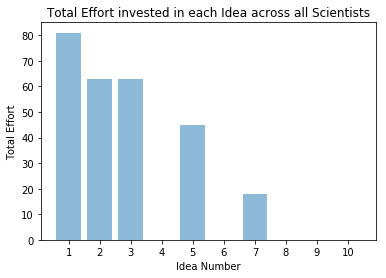

In [19]:
%matplotlib inline

import matplotlib.pyplot as plt

objects = ('1', '2', '3', '4', '5', '6', '7' ,'8', '9', '10')
idea_returns = random.choice(model.schedule.agents).current_idea_effort
y_pos = np.arange(len(objects))
plt.bar(y_pos, idea_returns, align='center', alpha = 0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Total Effort')
plt.title('Total Effort invested in each Idea across all Scientists')
plt.xlabel('Idea Number')

In [20]:
# Current Simulation:
# 1. Scientist invests in one idea per time period
# 2. Noise not added yet for global parameters
# 3. everyone gets the same effort when born
# 4. no updating with priors yet
# 5. Scientists currently know true distribution 

# For the distributions:
#     mean = max_effort/2
#     std_dev = steepness (higher = flatter, lower = steeper)

# Pass in: 
# the true distributions (mean, std_devs) of all the ideas
    
